In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import sys

sys.path.append("../")

from src.envs import RLFSEnvSparse
from src.rl.REINFORCE_baseline import REINFORCEWithBaselineAgent
from src.errors import sammon_error

In [2]:
INF_LOOP_CNT = 5

In [3]:
def get_data_frames(train_path, test_path):
    data_train = pd.read_csv(train_path, sep=",")
    data_test = pd.read_csv(test_path, sep=",")

    return data_train, data_test


def get_data_train_test(data_train, data_test):
    X_train = data_train.drop(columns=["repository"], inplace=False)
    X_train = X_train.to_numpy()

    X_test = data_test.drop(columns=["repository"], inplace=False)
    X_test = X_test.to_numpy()

    return X_train, X_test

def powers_of_two_less_than(n):
    max_exponent = int(np.log2(n))  # Find the largest exponent such that 2^k < N
    return 2 ** np.arange(max_exponent+1)

In [4]:
def train_reinforce_agent(X_train, agent, device, make_plots=False):
    state_space = X_train.shape[1]
    action_space = X_train.shape[1]
    for i, num_features in enumerate(powers_of_two_less_than(state_space//2)):
            env = RLFSEnvSparse(
                state_size=state_space, data=X_train, max_features=num_features
            )
            print(f"Iteration {i}, Number of features {num_features}")
            episode_returns = agent.train(
                env=env,
                num_episodes=500 + 1000 // (i+1),
                max_steps=num_features,
            )
            # print("Statistics:", "mean", agent.reward_mean, "std", agent.reward_variance/agent.running_count)
            # torch.save(agent.policy.state_dict(), "models/REINFORCE/policy_weights.pth")
            if make_plots:
                plt.plot(episode_returns)
                plt.show()

In [5]:
def test_agent(X_test, data_test, agent: REINFORCEWithBaselineAgent, verbose=True):
    state_space = X_test.shape[1]
    action_space = X_test.shape[1]
    print(state_space)
    env = RLFSEnvSparse(state_size=state_space, data=X_test, max_features=state_space)
    errors = []
    num_ftrs = []
    selected_features = []
    if verbose:
        print("waiting...")
    for n in range(1, state_space + 1):
        state = env.reset()
        # errors.append(sammon_error(X_test, state))
        state_cnt = 0  # int(np.sum(state))
        done = False
        # if verbose:
        #     print(f"n={n}")
        inf_loop_cnt = INF_LOOP_CNT
        action_sequence = []
        while state_cnt < n and not done:
            if inf_loop_cnt > 0:
                action, action_prob = agent.select_action_deterministic(state)
            else:
                # print("+")
                action, action_prob = agent.select_action(state)
                # print(np.exp(action_prob.detach().numpy()))

            next_state, _, done, _ = env.step(action)

            # if state changed
            if int(np.sum(next_state)) > state_cnt:
                # print(state_cnt)
                action_sequence.append(action)
                inf_loop_cnt = INF_LOOP_CNT
                state_cnt = int(np.sum(next_state))
            else:
                inf_loop_cnt -= 1
                continue

            state = next_state
        # print(np.sum(state))
        error = sammon_error(X_test, state)
        errors.append(error)
        num_ftrs.append(n)
        selected_features.append(
            [
                data_test.drop(columns=["repository"]).columns[action]
                for action in action_sequence
            ]
        )

    return errors, num_ftrs, selected_features

In [6]:
train_path_class = "../data/data_class_train.csv"
test_path_class = "../data/data_class.csv"
train_path_method = "../data/data_method_train.csv"
test_path_method = "../data/data_method.csv"

In [7]:
data_train_method, data_test_method = get_data_frames(train_path_method, test_path_method)
X_train_method, X_test_method = get_data_train_test(data_train_method, data_test_method)
state_space_method = X_train_method.shape[1]
action_space_method = X_train_method.shape[1]

data_train_class, data_test_class = get_data_frames(train_path_class, test_path_class)
X_train_class, X_test_class = get_data_train_test(data_train_class, data_test_class)
state_space_class = X_train_class.shape[1]
action_space_class = X_train_class.shape[1]

In [8]:
data_train_method.shape, data_test_method.shape

((53, 27), (106, 27))

In [9]:
data_train_class.shape, data_test_class.shape

((64, 31), (128, 31))

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = REINFORCEWithBaselineAgent(state_space_method, action_space_method, gamma=1, lr=0.0001)

In [11]:
def run_train_test(X_train, X_test, data_test, agent, device):
    train_reinforce_agent(X_train, agent, device)
    return test_agent(X_test, data_test, agent)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
agent_method = REINFORCEWithBaselineAgent(
    state_space_method, action_space_method, gamma=1, lr=0.001
)
errors, num_ftrs, selected_features = run_train_test(
    X_train=X_train_method,
    X_test=X_test_method,
    data_test=data_test_method,
    agent=agent_method,
    device=device,
)

print(selected_features)


Iteration 0, Number of features 1


Training Episodes:   0%|          | 0/1500 [00:00<?, ?it/s]/Users/yy7/Repos/EM-Team.4-Later/notebooks/../src/rl/REINFORCE_baseline.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  states_tensor = torch.tensor(self.states, dtype=torch.float32)
Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1047.53it/s, Return=3.85]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 973.57it/s, Return=5.26]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 756.39it/s, Return=6.24]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 540.33it/s, Return=7.75]


26
waiting...
[['HEFF'], ['HEFF', 'MI'], ['HEFF', 'MI', 'LOC'], ['HEFF', 'MI', 'LOC', 'HVOL'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC', 'DLOC'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC', 'DLOC', 'TCLOC'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC', 'DLOC', 'TCLOC', 'TLLOC'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC', 'DLOC', 'TCLOC', 'TLLOC', 'NII'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC', 'DLOC', 'TCLOC', 'TLLOC', 'NII', 'TNOS'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC', 'DLOC', 'TCLOC', 'TLLOC', 'NII', 'TNOS', 'McCC'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC', 'DLOC', 'TCLOC', 'TLLOC', 'NII', 'TNOS', 'McCC', 'HNDB'], ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC', 'DLOC', 'TCLOC', 'TLLOC', 'NII', 'TNOS', 'McCC', 'HNDB', 'HTRP'], ['HEFF', 'MI', 'LOC', 'HVOL'

In [14]:
selected_features_ = []
selected_features_.extend(selected_features[-1])

In [15]:
selected_features

[['HEFF'],
 ['HEFF', 'MI'],
 ['HEFF', 'MI', 'LOC'],
 ['HEFF', 'MI', 'LOC', 'HVOL'],
 ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC'],
 ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC'],
 ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC'],
 ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC', 'DLOC'],
 ['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'LLOC', 'CLOC', 'DLOC', 'TCLOC'],
 ['HEFF',
  'MI',
  'LOC',
  'HVOL',
  'TLOC',
  'LLOC',
  'CLOC',
  'DLOC',
  'TCLOC',
  'TLLOC'],
 ['HEFF',
  'MI',
  'LOC',
  'HVOL',
  'TLOC',
  'LLOC',
  'CLOC',
  'DLOC',
  'TCLOC',
  'TLLOC',
  'NII'],
 ['HEFF',
  'MI',
  'LOC',
  'HVOL',
  'TLOC',
  'LLOC',
  'CLOC',
  'DLOC',
  'TCLOC',
  'TLLOC',
  'NII',
  'TNOS'],
 ['HEFF',
  'MI',
  'LOC',
  'HVOL',
  'TLOC',
  'LLOC',
  'CLOC',
  'DLOC',
  'TCLOC',
  'TLLOC',
  'NII',
  'TNOS',
  'McCC'],
 ['HEFF',
  'MI',
  'LOC',
  'HVOL',
  'TLOC',
  'LLOC',
  'CLOC',
  'DLOC',
  'TCLOC',
  'TLLOC',
  'NII',
  'TNOS',
  'McCC',
  'HNDB'],
 ['HEFF',
  'MI',
  'LOC',
  'HVOL',
  

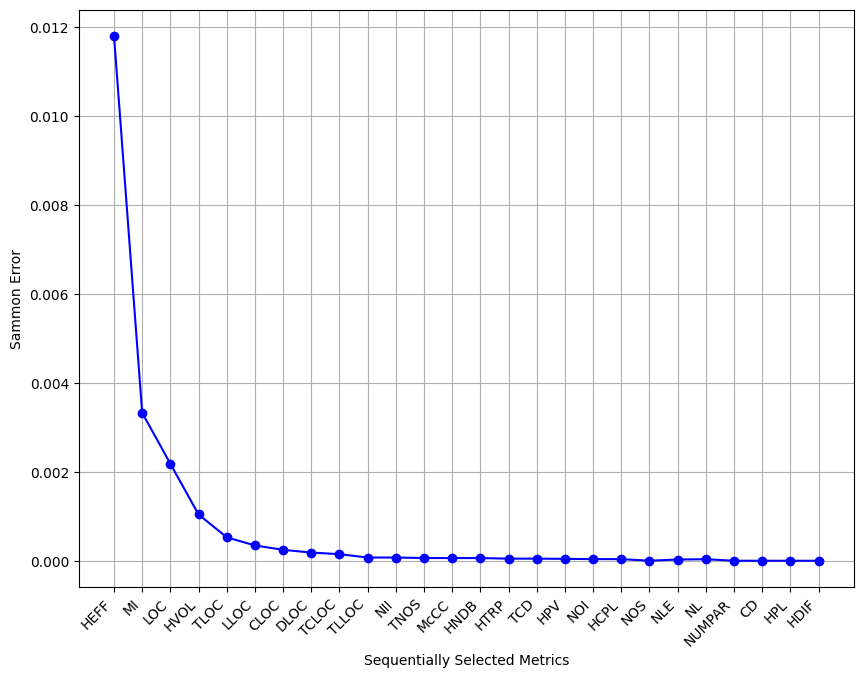

In [16]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Sequentially Selected Metrics')
plt.ylabel('Sammon Error')
# plt.title('Sammon Error vs Number of Features')
plt.xticks(num_ftrs, selected_features_, rotation=45, ha='right')  # Map indices to feature names
plt.grid(True)
plt.show()

In [17]:
agent_class = REINFORCEWithBaselineAgent(
    state_space_class, action_space_class, gamma=1, lr=0.001
)
errors, num_ftrs, selected_features = run_train_test(
    X_train=X_train_class,
    X_test=X_test_class,
    data_test=data_test_class,
    agent=agent_class,
    device=device,
)

Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1092.82it/s, Return=1.35]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 960.13it/s, Return=2.3]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 746.24it/s, Return=3.79]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 536.91it/s, Return=7.88]


30
waiting...


In [18]:
selected_features_ = []
selected_features_.extend(selected_features[-1])

In [19]:
print(selected_features_)

['TLOC', 'LOC', 'LLOC', 'TLLOC', 'CLOC', 'TNOS', 'NOS', 'WMC', 'TNM', 'TNLM', 'NOC', 'NL', 'NOP', 'NLM', 'DIT', 'NII', 'NA', 'RFC', 'LCOM5', 'TNLA', 'CD', 'NOD', 'NOI', 'NM', 'NOA', 'NLA', 'NLE', 'CBOI', 'CBO', 'TNA']


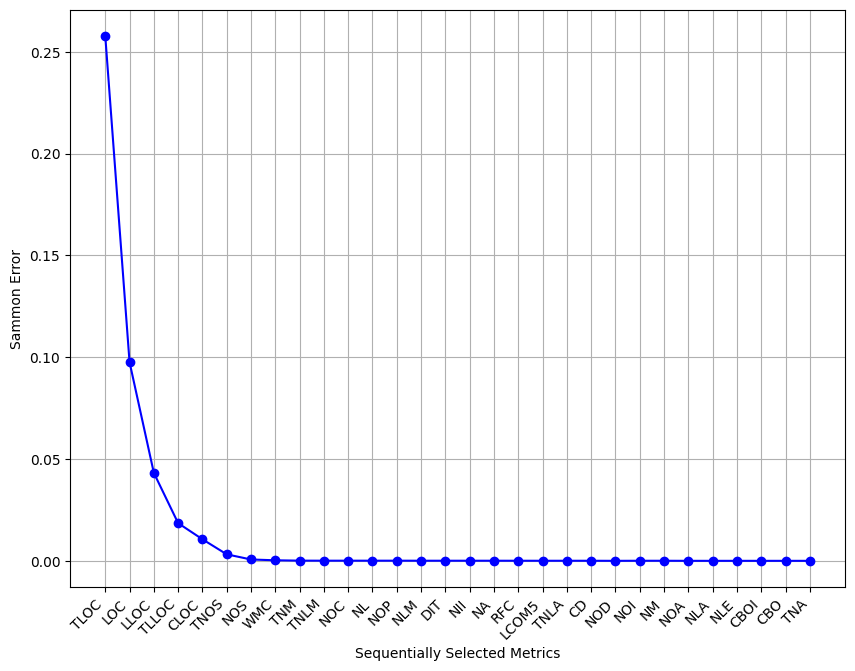

In [20]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(num_ftrs, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Sequentially Selected Metrics')
plt.ylabel('Sammon Error')
# plt.title('Sammon Error vs Number of Features')
plt.xticks(num_ftrs, selected_features_, rotation=45, ha='right')  # Map indices to feature names
plt.grid(True)
plt.show()

In [21]:
def test_stability(X_train, X_test, data_test, num_iters=10):
    state_space = X_train.shape[1]
    action_space = X_train.shape[1]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    all_errors = []
    all_num_ftrs = []
    all_selected_features = []
    for i in range(num_iters):
        agent = REINFORCEWithBaselineAgent(state_space, action_space, gamma=1, lr=0.001)
        errors, num_ftrs, selected_features = run_train_test(
            X_train, X_test, data_test, agent, device
        )
        all_errors.append(errors)
        all_num_ftrs.append(num_ftrs)
        all_selected_features.append(selected_features)

    return all_errors, all_num_ftrs, all_selected_features

In [22]:
all_errors, all_num_ftrs, all_selected_features = test_stability(X_train_class, X_test_class, data_test_class, num_iters=10)

Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1111.79it/s, Return=1.35]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 939.34it/s, Return=2.3] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 736.91it/s, Return=3.79]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 529.88it/s, Return=7.88]


30
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1167.94it/s, Return=1.35]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 913.24it/s, Return=2.3]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 736.32it/s, Return=3.79]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 415.46it/s, Return=7.42]


30
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 876.35it/s, Return=1.35]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 799.45it/s, Return=2.3]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 724.51it/s, Return=3.79]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 516.62it/s, Return=7.42]


30
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 874.06it/s, Return=1.35]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 634.56it/s, Return=2.3]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 703.01it/s, Return=3.79]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 508.59it/s, Return=7.88]


30
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1089.13it/s, Return=1.35]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 901.48it/s, Return=2.3]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 742.41it/s, Return=3.79]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 518.91it/s, Return=6.91]


30
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1105.36it/s, Return=1.35]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 896.83it/s, Return=2.3]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 738.76it/s, Return=3.63]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 520.22it/s, Return=7.88]


30
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1078.68it/s, Return=1.35]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 925.69it/s, Return=2.3]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 694.19it/s, Return=3.79]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 507.53it/s, Return=7.88]


30
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1050.46it/s, Return=1.35]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 894.81it/s, Return=2.3] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 728.66it/s, Return=3.79]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 413.54it/s, Return=5.8] 


30
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1113.89it/s, Return=1.35]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 894.11it/s, Return=2.3]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 710.70it/s, Return=3.79]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 516.23it/s, Return=7.88]


30
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1138.90it/s, Return=1.35]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 918.82it/s, Return=2.3]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 738.37it/s, Return=3.06]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 522.88it/s, Return=5.89]


30
waiting...


In [23]:
min_errors = np.min(all_errors, axis=0)
max_errors = np.max(all_errors, axis=0)
avg_errors = np.mean(all_errors, axis=0)
min_errors, max_errors, avg_errors

(array([2.57124478e-01, 9.75449645e-02, 4.31939462e-02, 1.85016886e-02,
        7.79003105e-03, 3.19280335e-03, 6.63314552e-04, 2.65971245e-04,
        9.46305014e-05, 7.23670215e-05, 7.23670215e-05, 3.23332099e-05,
        1.70777108e-05, 1.70190517e-05, 1.69188362e-05, 1.64144856e-05,
        2.55652148e-06, 6.53124746e-06, 6.36505645e-06, 1.07151488e-06,
        1.00576320e-06, 2.26044823e-06, 2.20108630e-06, 9.89465820e-07,
        4.02062040e-09, 5.91032200e-10, 6.40932674e-09, 1.99403505e-20,
        1.99403505e-20, 1.99403505e-20]),
 array([2.57776690e-01, 9.75449645e-02, 4.32746858e-02, 2.66292282e-02,
        1.05866600e-02, 3.67713718e-03, 2.96914129e-03, 6.61892595e-04,
        6.61892595e-04, 4.09931342e-04, 3.68280937e-04, 3.67963373e-04,
        3.67270115e-04, 3.67270115e-04, 3.66593073e-04, 3.66593073e-04,
        3.65920518e-04, 3.36251392e-04, 3.36251392e-04, 2.71116606e-04,
        3.35965355e-04, 2.45780985e-04, 2.03680956e-04, 2.45780985e-04,
        2.03150153e-04

In [24]:
df_reinforce_class = pd.DataFrame({
    "number_of_features": all_num_ftrs[0],
    "min_error": min_errors,
    "max_error": max_errors,
    "avg_error": avg_errors
})
df_reinforce_class

,number_of_features,min_error,max_error,avg_error
0,1,2.571245e-01,2.577767e-01,2.576462e-01
1,2,9.754496e-02,9.754496e-02,9.754496e-02
2,3,4.319395e-02,4.327469e-02,4.324239e-02
3,4,1.850169e-02,2.662923e-02,1.931444e-02
4,5,7.790031e-03,1.058666e-02,8.913562e-03
5,6,3.192803e-03,3.677137e-03,3.289686e-03
6,7,6.633146e-04,2.969141e-03,1.054567e-03
7,8,2.659712e-04,6.618926e-04,3.337579e-04
8,9,9.463050e-05,6.618926e-04,2.796950e-04
9,10,7.236702e-05,4.099313e-04,2.138773e-04


In [33]:
df_reinforce_class.to_csv("../data/results/REINFORCE_baseline_class.csv", index=False)

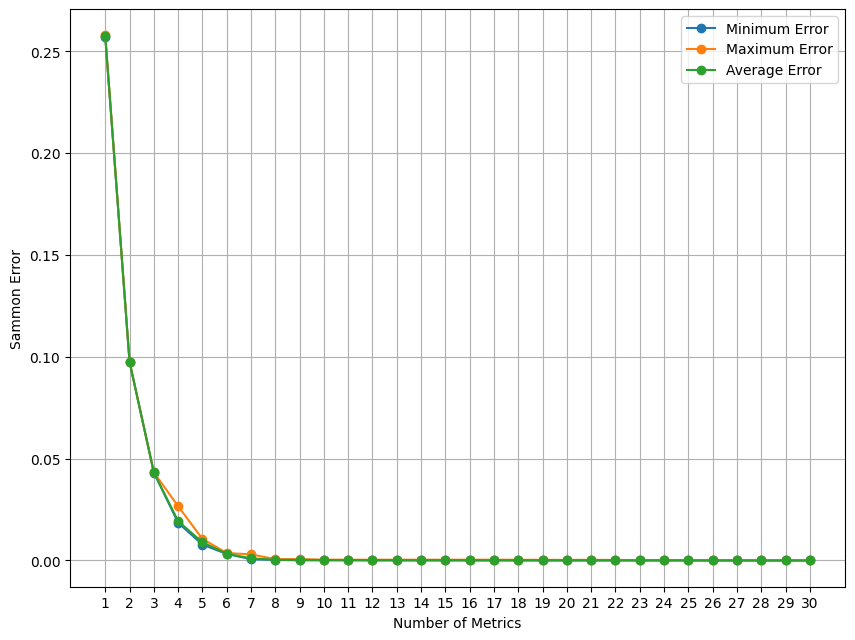

In [26]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(all_num_ftrs[0], min_errors, marker='o', label='Minimum Error')
plt.plot(all_num_ftrs[0], max_errors, marker='o', label='Maximum Error')
plt.plot(all_num_ftrs[0], avg_errors, marker='o', label='Average Error')

# Add plot details
plt.xlabel('Number of Metrics')
plt.ylabel('Sammon Error')
# plt.title('Model Stability across Retrainings')
plt.xticks(all_num_ftrs[0])  # Ensure x-axis ticks are integers from all_num_ftrs
plt.legend()
plt.grid(True)
plt.show()

In [27]:
all_errors_m, all_num_ftrs_m, all_selected_features_m = test_stability(X_train_method, X_test_method, data_test_method, num_iters=10)

Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1101.26it/s, Return=3.85]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 772.34it/s, Return=5.26]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 724.47it/s, Return=6.24]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 520.58it/s, Return=8.14]


26
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1133.20it/s, Return=3.85]   


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 979.44it/s, Return=5.26]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 747.09it/s, Return=6.23]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 521.76it/s, Return=7.55]


26
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1131.51it/s, Return=3.85]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 968.41it/s, Return=5.26]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 742.92it/s, Return=6.24]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 525.10it/s, Return=8.14]


26
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1144.40it/s, Return=3.85]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 931.95it/s, Return=5.26]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 751.32it/s, Return=6.24]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 521.87it/s, Return=8.16]


26
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1154.86it/s, Return=3.85]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 973.75it/s, Return=5.26] 


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 750.32it/s, Return=6.24]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 528.59it/s, Return=7.12]


26
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1116.52it/s, Return=3.85]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 966.91it/s, Return=5.26]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 749.09it/s, Return=6.23]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 515.47it/s, Return=7.74]


26
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1150.69it/s, Return=3.85]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 961.06it/s, Return=5.26]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 725.48it/s, Return=6.24]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 523.31it/s, Return=8.2] 


26
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1158.99it/s, Return=3.85]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 972.69it/s, Return=5.26]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 745.49it/s, Return=6.24]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 530.06it/s, Return=7.79]


26
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1131.88it/s, Return=3.85]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 936.74it/s, Return=5.26]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 713.97it/s, Return=6.23]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 517.79it/s, Return=8.19]


26
waiting...
Iteration 0, Number of features 1


Training Episodes: 100%|██████████| 1500/1500 [00:01<00:00, 1067.73it/s, Return=3.85]  


Iteration 1, Number of features 2


Training Episodes: 100%|██████████| 1000/1000 [00:01<00:00, 967.62it/s, Return=5.26]


Iteration 2, Number of features 4


Training Episodes: 100%|██████████| 833/833 [00:01<00:00, 736.72it/s, Return=6.25]


Iteration 3, Number of features 8


Training Episodes: 100%|██████████| 750/750 [00:01<00:00, 524.28it/s, Return=8.07]


26
waiting...


In [28]:
print(all_selected_features_m[0][-1])
print([float(error) for error in all_errors_m[0]])

['HEFF', 'MI', 'LOC', 'HVOL', 'TLOC', 'TLLOC', 'CLOC', 'LLOC', 'DLOC', 'HPV', 'NUMPAR', 'NOS', 'TNOS', 'HCPL', 'McCC', 'NOI', 'TCLOC', 'NII', 'HPL', 'TCD', 'HTRP', 'NLE', 'HDIF', 'CD', 'NL', 'HNDB']
[0.011813886698870594, 0.0033288724293837465, 0.002183144915780891, 0.001041893742704388, 0.0005286542611848264, 0.0003401806494834744, 0.00024215515561974306, 0.00015540611967529612, 0.00010054902940282661, 9.412808303402579e-05, 9.144519698535666e-05, 7.910730744781337e-05, 6.866700799013186e-05, 1.7799811277313696e-05, 1.7211155029303632e-05, 1.7187871983570046e-05, 4.0508097079984045e-06, 7.165899201587348e-07, 2.056539738746264e-06, 9.435473991276468e-11, 4.170330986079913e-18, 4.02621684337535e-06, 4.170330986079913e-18, 4.170330986079913e-18, 1.3786943288452742e-20, 1.3786943288452742e-20]


In [29]:
min_errors = np.min(all_errors_m, axis=0)
max_errors = np.max(all_errors_m, axis=0)
avg_errors = np.mean(all_errors_m, axis=0)
min_errors, max_errors, avg_errors

(array([1.18138867e-02, 3.32887243e-03, 1.95967979e-03, 1.03562596e-03,
        5.28654261e-04, 3.40180649e-04, 2.40667091e-04, 1.53004767e-04,
        9.93594888e-05, 3.56567531e-05, 1.53853721e-05, 9.69927210e-06,
        5.22488352e-06, 2.83102750e-06, 2.88786950e-06, 4.24409124e-06,
        1.53436311e-06, 7.16589920e-07, 7.21468241e-08, 9.43547399e-11,
        4.17033099e-18, 6.79200176e-08, 4.17033099e-18, 1.37869433e-20,
        1.37869433e-20, 1.37869433e-20]),
 array([1.18138867e-02, 3.32887243e-03, 2.18314492e-03, 1.51914040e-03,
        5.28654261e-04, 4.20825635e-04, 2.47033657e-04, 1.84300095e-04,
        1.48562640e-04, 9.41280830e-05, 9.14451970e-05, 7.91073074e-05,
        6.86670080e-05, 4.57628453e-05, 4.51764622e-05, 6.81889565e-05,
        9.67052259e-06, 9.45758340e-06, 9.45758340e-06, 3.69259862e-05,
        5.64963465e-06, 3.79760093e-05, 2.60607535e-06, 2.06782526e-06,
        4.01281769e-07, 1.37869433e-20]),
 array([1.18138867e-02, 3.32887243e-03, 2.13601769e-

In [30]:
df_reinforce_method = pd.DataFrame({
    "number_of_features": all_num_ftrs_m[0],
    "min_error": min_errors,
    "max_error": max_errors,
    "avg_error": avg_errors
})
df_reinforce_method

,number_of_features,min_error,max_error,avg_error
0,1,1.181389e-02,1.181389e-02,1.181389e-02
1,2,3.328872e-03,3.328872e-03,3.328872e-03
2,3,1.959680e-03,2.183145e-03,2.136018e-03
3,4,1.035626e-03,1.519140e-03,1.088365e-03
4,5,5.286543e-04,5.286543e-04,5.286543e-04
5,6,3.401806e-04,4.208256e-04,3.496720e-04
6,7,2.406671e-04,2.470337e-04,2.440488e-04
7,8,1.530048e-04,1.843001e-04,1.691689e-04
8,9,9.935949e-05,1.485626e-04,1.054863e-04
9,10,3.565675e-05,9.412808e-05,7.003964e-05


In [31]:
df_reinforce_method.to_csv("../data/results/REINFORCE_method.csv", index=False)

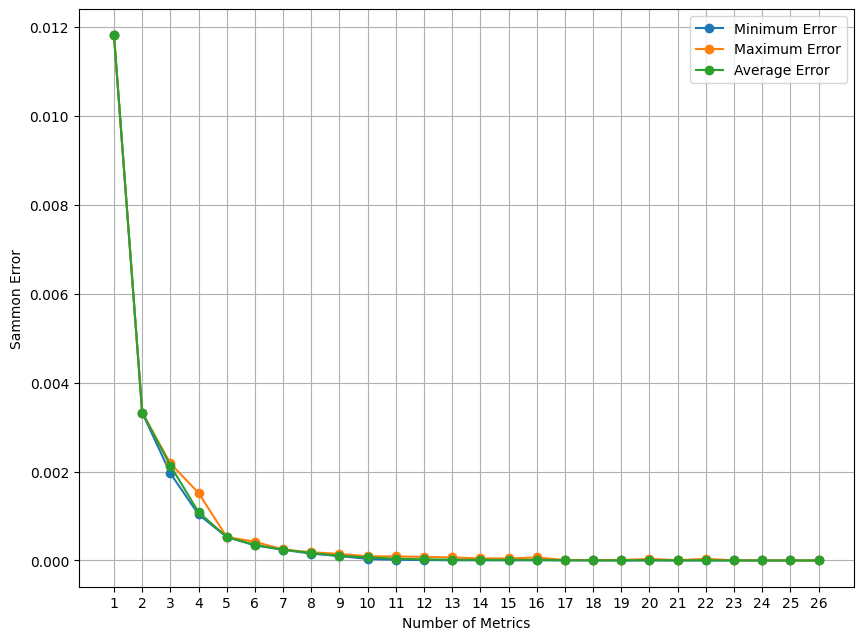

In [32]:
# Plot
plt.figure(figsize=(10, 7.5))
plt.plot(all_num_ftrs_m[0], min_errors, marker='o', label='Minimum Error')
plt.plot(all_num_ftrs_m[0], max_errors, marker='o', label='Maximum Error')
plt.plot(all_num_ftrs_m[0], avg_errors, marker='o', label='Average Error')

# Add plot details
plt.xlabel('Number of Metrics')
plt.ylabel('Sammon Error')
# plt.title('Model Stability across Retrainings')
plt.xticks(all_num_ftrs_m[0])  # Ensure x-axis ticks are integers from all_num_ftrs
plt.legend()
plt.grid(True)
plt.show()

In [34]:
df_reinforce_method.to_csv("../data/results/REINFORCE_baseline_method.csv", index=False)